# SHAP Values
    Unified Local and Global Model Interpretability
##  Objective

This notebook demonstrates how to use SHAP values to:

- Explain individual predictions (local interpretability)

- Aggregate explanations into global feature importance

- Understand direction, magnitude, and interaction effects

- Support model governance, audits, and adverse action explanations

It answers:

> Why did the model make this specific prediction — and what patterns emerge across the population?

##  Why SHAP?

SHAP is based on cooperative game theory and provides:

- ✔ Local explanations
- ✔ Global aggregation
- ✔ Consistent attribution
- ✔ Model-agnostic & model-specific methods

It is widely accepted in:

- Credit risk & PD modeling

- Fraud detection

- Pricing and underwriting

- Regulatory model reviews

##  Conceptual Foundation

Each prediction is decomposed as:

>> $ Prediction = Base Value+∑ SHAP Contributions$

Where:

- Base value = average model prediction

- SHAP value = marginal contribution of a feature

📌 SHAP values are additive and comparable across features

##  Imports and Dataset

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [8]:
DATA_PATH = '''D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv'''

df = pd.read_csv(DATA_PATH)

X = df.drop(columns=["default", "customer_id"])
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=2010
)


# Train Reference Models
## Logistic Regression (Interpretable Baseline)

In [11]:
logit = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

logit.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## Random Forest (Non-Linear Model)

In [14]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=300,
                       random_state=42)

## SHAP for Logistic Regression (LinearExplainer)

SHAP can exactly explain linear models.

In [17]:
X_train_transformed = logit.named_steps["scaler"].transform(
    logit.named_steps["imputer"].transform(X_train)
)

explainer_logit = shap.LinearExplainer(
    logit.named_steps["model"],
    X_train_transformed,
    feature_names=X.columns
)

shap_values_logit = explainer_logit(
    logit.named_steps["scaler"].transform(
        logit.named_steps["imputer"].transform(X_test)
    )
)


## Global SHAP Summary (Logistic Regression)

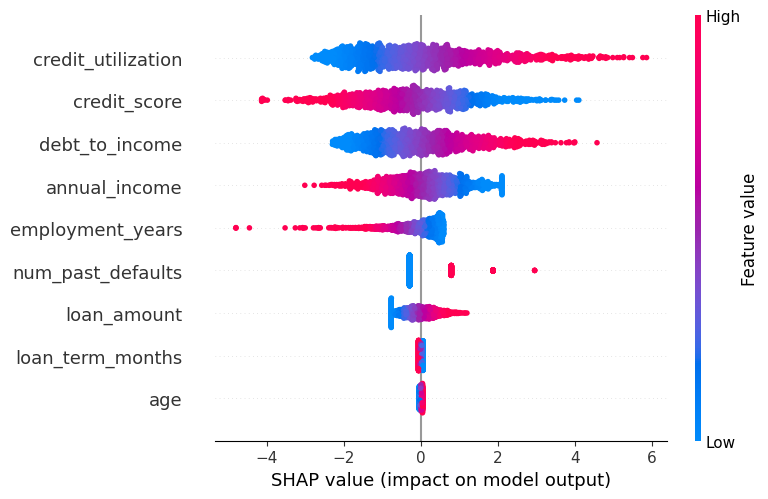

In [20]:
shap.summary_plot(
    shap_values_logit,
    features=X_test,
    feature_names=X.columns
)


📌 Shows:

Feature importance (global)

Direction of effect

Distribution of impacts

## SHAP for Random Forest (TreeExplainer)

In [23]:
explainer_rf = shap.TreeExplainer(rf)

shap_values_rf = explainer_rf.shap_values(X_test)


## Global Summary Plot (Random Forest)

In [28]:
shap.summary_plot(
    shap_values_rf[1],
    X_test,
    feature_names=X.columns
)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Captures:

- Non-linear effects

- Threshold behavior

- Feature interactions

## Local Explanation (Single Observation)

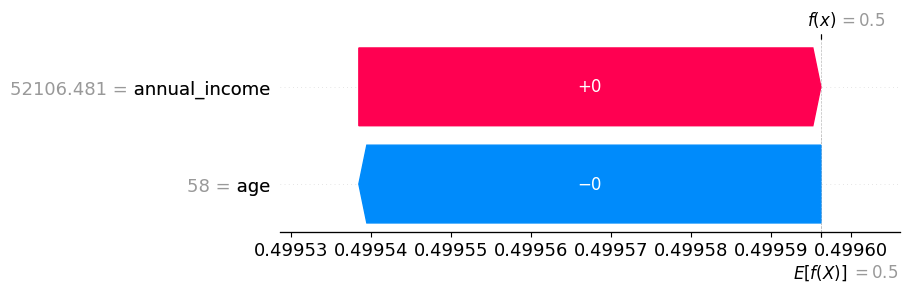

In [33]:
i = 0  # index of customer

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_rf[1][i],
        base_values=explainer_rf.expected_value[1],
        data=X_test.iloc[i],
        feature_names=X.columns
    )
)


✔ Explains why this customer was classified as high risk
✔ Suitable for adverse action explanations

## Force Plot (Optional)

In [37]:
shap.force_plot(
    explainer_rf.expected_value[1],
    shap_values_rf[1][i],
    X_test.iloc[i],
    matplotlib=True
)


DimensionError: Length of features is not equal to the length of shap_values!

## Dependence Plot (Interaction-Aware)

In [39]:
shap.dependence_plot(
    "credit_utilization",
    shap_values_rf[1],
    X_test,
    interaction_index="income"
)


ValueError: Could not find feature named: income

Reveals:

- Non-linear relationships

- Feature interactions

- Regime shifts

# SHAP vs PDP vs Permutation


| Method      | Local | Global | Interactions |
| ----------- | ----- | ------ | ------------ |
| PDP         | ❌     | ✔      | Limited      |
| Permutation | ❌     | ✔      | ❌            |
| SHAP        | ✔✔    | ✔✔     | ✔✔           |


## Common Pitfalls (Avoided)

- ❌ Explaining raw pipelines incorrectly
- ❌ Using KernelExplainer unnecessarily
- ❌ Interpreting SHAP as causal
- ❌ Ignoring class-specific outputs
- ❌ Explaining unstable models

## Best Practices

- ✔ Fix preprocessing before explanation
- ✔ Use SHAP on final model only
- ✔ Combine global + local views
- ✔ Archive explanations for audits
- ✔ Validate stability across folds

## Key Takeaways

- SHAP is the most complete explanation framework

- Explains both individual decisions and population behavior

- Required for regulated ML systems

- Complements PDP and permutation importance

- Interpretation still requires domain judgment

## Next Notebook

[08_Interpretability_and_Explainability/]()

├── [02_local_interpretability/]()

│   └── [02_lime_explanations.ipynb](02_lime_explanations.ipynb)
